### Import the necessary libraries

In [1]:
import pickle 
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
# %matplotlib inline

import os
import warnings
import itertools

from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut, GridSearchCV
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

np.random.seed(10)

os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

### Create function to plot Confusion Matrix without Normalization

In [3]:
def plot_confusion_matrix(cm, model_name):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Drug Response Prediction Confusion Matrix without Normalization')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    classNames = ['Refractory','Responsive']
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    # set the layout approach without normalization
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(s[i][j])+" = "+str(cm[i][j]))
    # save plot as image 
    plt.savefig('./figures/default-confusion-matrixes/%s-default-cm' % model_name.lower())
    plt.show()    

### Create function to plot a Normalized Confusion Matrix

In [4]:
def plot_normalized_confusion_matrix(cm, model_name, use_portuguese=True):
    # apply normalization
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # plot matrix
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # check language to be used
    if(use_portuguese):
        plt.title('Dados clínicos - Matriz de Confusão Normalizada')
        plt.colorbar()
        plt.ylabel('Rótulo verdadeiro') 
        plt.xlabel('Rótulo previsto') 
        classNames = ['Refratário','Responsivo'] 
    else:
        plt.title('Clinical data - Normalized Confusion Matrix')
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        classNames = ['Refractory','Responsive']
    
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    # set the normalized layout approach
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    # save plot as image 
    plt.savefig('./figures/normalized-confusion-matrixes/%s-clinical-normalized-cm' % model_name.lower())
    plt.show()

### Create function to plot ROC curve

In [5]:
def plot_roc_curve(fpr, tpr, auc_score, model_name, use_portuguese=True):
    plt.figure(1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    plt.plot(fpr, tpr, color='darkorange', label='AUC = %f)' % auc_score)
    
    # check language to be used
    if(use_portuguese):    
        plt.xlabel('Taxa de falsos positivos')
        plt.ylabel('Taxa de verdadeiros positivos') 
        plt.title('Dados clínicos - Curva ROC') 
    else:
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('Clinical data - ROC Curve')
    
    plt.legend(loc='best')
    # save plot as image 
    plt.savefig('./figures/roc-curves/%s-clinical-roc-curve' % model_name.lower())
    plt.show()

### Create function to be used to perform model fitting using LOOCV 

In [6]:
def fit_model(model, X, y):
    
    # prepare a LOOCV validator (number of folds equals the number of samples)
    loocv = LeaveOneOut()
    loocv.get_n_splits(X)
    
    # perform cross-validation and get the accuracies
    cv_score = cross_val_score(model, X, y, cv=loocv, scoring='accuracy') 
    
    # perform cross-validation and get the predictions and predictions probabilities
    preds = cross_val_predict(model, X, y, cv=loocv)
    predprobs = cross_val_predict(model, X, y, cv=loocv, method='predict_proba')[:,1]
    
    # calculate fpr and tpr values using the y_true and predictions probabilities
    fpr, tpr, _ = metrics.roc_curve(y, predprobs)
    
    # calculate the auc score based on fpr and tpr values
    auc_score = metrics.auc(fpr, tpr)

    # generate the confusion matrix for the model results
    cm = metrics.confusion_matrix(y, preds)
    
    # print model report
    print("\nModel Report\n")
    print(model) # print the used params for the model
    print("\nAccuracy (CV Score) : Mean - %.7g | Std - %.7g" % (np.mean(cv_score), np.std(cv_score)))
    print("\nAUC Score : %f" % auc_score)
    print("\n" + metrics.classification_report(y, preds)) # print a complete classification metrics report
    
    # get current model name
    model_name = str(model).split('(')[0]
    
    # plot confusion matrix
    plot_confusion_matrix(cm, model_name)
    
    # plot normalized confusion matrix
    plot_normalized_confusion_matrix(cm, model_name) # gets only the mod

    # plot the roc curve
    plot_roc_curve(fpr, tpr, auc_score, model_name)
    
    return predprobs # return prediction probabilities to be used on meta-learning step

### Get preprocessed clinical data (241 samples)

In [18]:
X = pickle.load(open( "../data/preprocessed/article-clinical-data-features.p", "rb"))
y = pickle.load(open( "../data/preprocessed/article-clinical-data-labels.p", "rb"))

# check data types
print(type(X))
print(type(y))

# TODO: check usage of normalization on this column (https://chrisalbon.com/python/data_wrangling/pandas_normalize_column/)
X = X.drop('age_onset', axis=1)

# check current features dataframe
X.head()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


,age_onset_groups,febrile_seizures_no,febrile_seizures_yes,gender_male,gender_female,hippocampal_sclerosis_no,hippocampal_sclerosis_yes
0,3.0,1,0,1,0,1,0
1,1.0,1,0,0,1,1,0
2,2.0,1,0,0,1,1,0
3,3.0,1,0,0,1,0,1
4,1.0,1,0,1,0,1,0


### Create a DecisionTreeClassifier baseline model using default parameters


Model Report

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=10, splitter='best')

Accuracy (CV Score) : Mean - 0.6846473 | Std - 0.4646562

AUC Score : 0.653422

             precision    recall  f1-score   support

          0       0.72      0.86      0.79       162
          1       0.53      0.33      0.41        79

avg / total       0.66      0.68      0.66       241



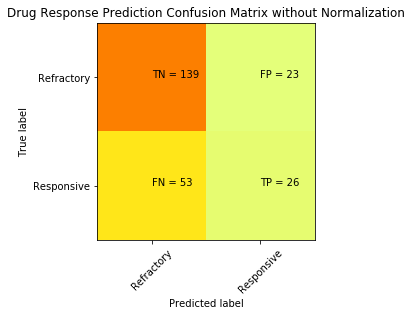

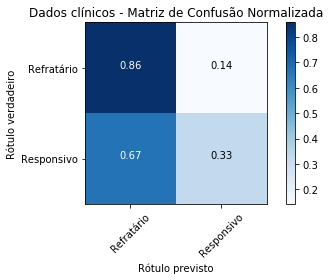

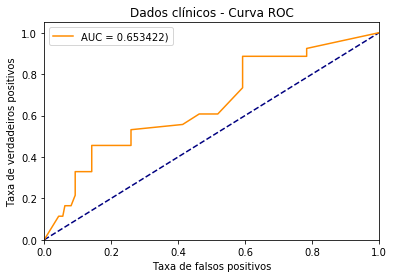

In [14]:
dt = DecisionTreeClassifier(random_state=10)

# perform model fitting
dt_predprobs = fit_model(dt, X, y)

# export prediction probabilities 
pickle.dump(dt_predprobs, open("./predictions/dt-clinical-predprobs.p", "wb"))

### Create a RandomForestClassifier baseline model using default parameters


Model Report

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

Accuracy (CV Score) : Mean - 0.6639004 | Std - 0.4723734

AUC Score : 0.648656

             precision    recall  f1-score   support

          0       0.72      0.83      0.77       162
          1       0.48      0.33      0.39        79

avg / total       0.64      0.66      0.64       241



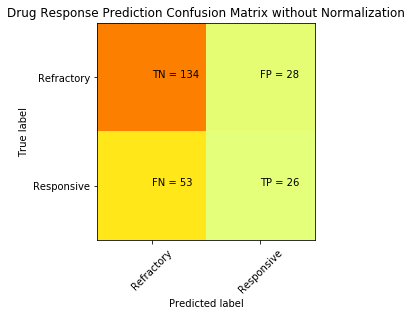

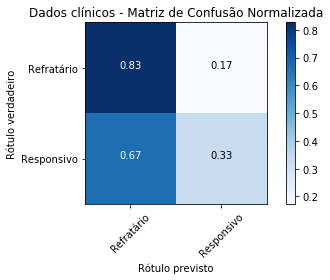

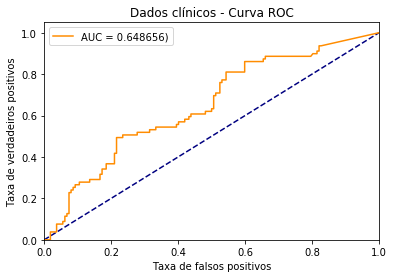

In [15]:
rf = RandomForestClassifier(random_state=10)

# perform model fitting
rf_predprobs = fit_model(rf, X, y)

# export prediction probabilities 
pickle.dump(rf_predprobs, open("./predictions/rf-clinical-predprobs.p", "wb"))

### Create a SVM baseline model using a reduced set of tuned parameters

In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [0.01, 1, 10, 100]}, 
                    {'kernel': ['linear'], 'C': [0.01, 1, 10, 100]}]

clf = GridSearchCV(SVC(probability=True, random_state=10), tuned_parameters)

# perform model fitting
svc_predprobs = fit_model(clf, X, y)

# export prediction probabilities 
pickle.dump(svc_predprobs, open("./predictions/svc-clinical-predprobs.p", "wb"))

### Create a GBM baseline model using default parameters

In [ ]:
gbm = GradientBoostingClassifier(random_state=10)

# perform model fitting
gbm_predprobs = fit_model(gbm, X, y)

# export prediction probabilities 
pickle.dump(gbm_predprobs, open("./predictions/gbm-clinical-predprobs.p", "wb"))

### Create a XGB baseline model using default parameters

In [ ]:
xgb = XGBClassifier()

# ignore deprecation warnings
#warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# perform model fitting
xgb_predprobs = fit_model(xgb, X, y)

# export prediction probabilities 
pickle.dump(xgb_predprobs, open("./predictions/xgb-clinical-predprobs.p", "wb"))

### Compare all generated ROC curves

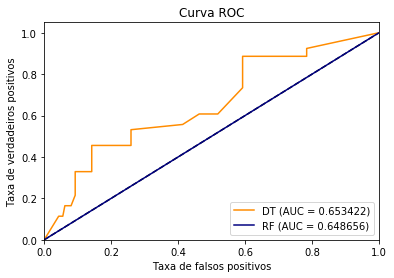

In [17]:
# calculate fpr, tpr and auc score for all models using the y_true and its predictions probabilities

fpr_dt, tpr_dt, _ = metrics.roc_curve(y, dt_predprobs)
auc_dt = metrics.auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = metrics.roc_curve(y, rf_predprobs)
auc_rf = metrics.auc(fpr_rf, tpr_rf)

fpr_svc, tpr_svc, _ = metrics.roc_curve(y, svc_predprobs)
auc_svc = metrics.auc(fpr_svc, tpr_svc)

fpr_gbm, tpr_gbm, _ = metrics.roc_curve(y, gbm_predprobs)
auc_gbm = metrics.auc(fpr_gbm, tpr_gbm)

fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y, xgb_predprobs)
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

# plot all roc curves into the same image

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')  , 
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.plot(fpr_dt, tpr_dt, color='darkorange', label='DT (AUC = %f)' % auc_dt)
plt.plot(fpr_rf, fpr_rf, color='navy', label='RF (AUC = %f)' % auc_rf)
plt.plot(fpr_svc, fpr_svc, color='aqua', label='SVM (AUC = %f)' % auc_svc)
plt.plot(fpr_gbm, fpr_gbm, color='cornflowerblue', label='GBDT (AUC = %f)' % auc_gbm)
plt.plot(fpr_xgb, fpr_xgb, color='deeppink', label='XBG (AUC = %f)' % auc_xgb)
plt.xlabel('Taxa de falsos positivos') # False positive rate
plt.ylabel('Taxa de verdadeiros positivos') # True positive rate
plt.title('Curva ROC') # Drug Response Prediction - ROC Curve
plt.legend(loc='lower right')
# save plot as image 
plt.savefig('./figures/roc-curves/model-comparison-roc-curves')
plt.show()